# Detecting Genomic Variants Associated With Anterior Cruciate Ligament (ACL) Rupture In Dogs

`Baker, Lauren A. et al. (2018). Genome-wide association analysis in dogs implicates 99 loci as risk variants for anterior cruciate ligament rupture. Dryad. https://doi.org/10.5061/dryad.8kk06`

__Summary__ \
The ACL is a ligament that connects the thighbone to the shinbone, stabilizing the knee joint. While certain types of physical activity are risk factors for an ACL injury, heritability studies have shown a genetic contribution to increased risk of ligament rupture. ACL rupture is common in humans and dogs. The risk of ACL is higher in femailes and some dog breeds.

__Dataset__ \
237 Labrador retrievers phenotyped for ACL rupture: 1 = 139 unaffected, 2 = 98 affected

__Project__ \
Here I try to reproduce the GWAS study and findings published by Baker et al., 2018.


In [56]:
d = {'Excluded_MAF_≤0.05':49859,
     'Excluded_Genotyping_≤95':7468,
     'Excluded_Deviation_HWE_P≥1E-07':153,
     'SNPS_After_QC':118992
    }

qc_numbers = pd.DataFrame([d])

qc_numbers

,Excluded_MAF_≤0.05,Excluded_Genotyping_≤95,Excluded_Deviation_HWE_P≥1E-07,SNPS_After_QC
0,49859,7468,153,118992


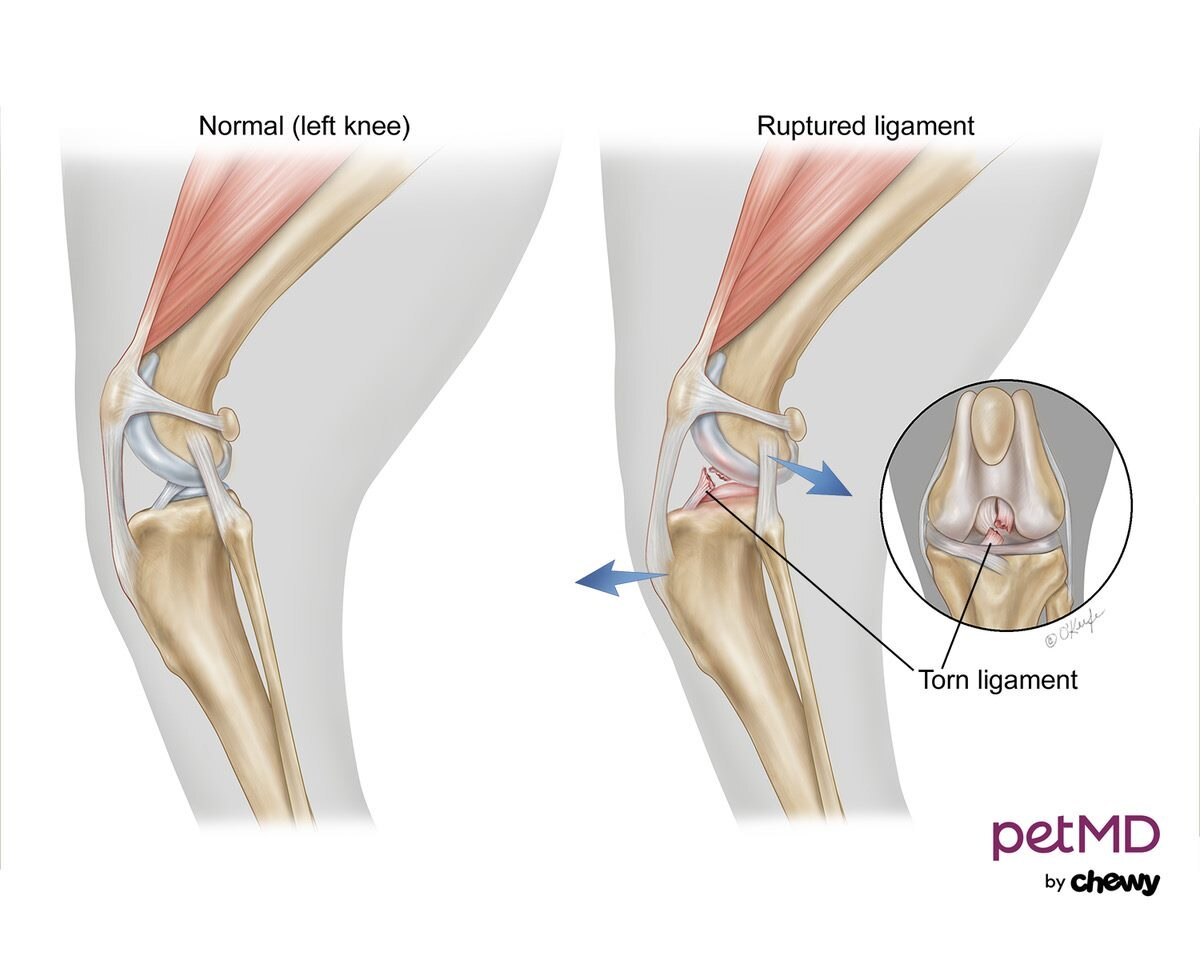

In [48]:
from IPython.display import Image

Image(filename='images/torn_knee.jpeg', width=600, height=450)


In [8]:
import subprocess
import pandas as pd
import numpy as np
import re
import gzip
import pybedtools
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
def run_plink(command, analysis):
    try:
        result = subprocess.check_output(command, shell=True, text=True)
        print(result)
        print(f"{analysis} analysis completed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error executing {analysis} analysis:", e)

def column_name_mapping(df):
    df = df.rename(columns={df.columns[0]: 'Chr', 
                            df.columns[1]: 'Start', 
                            df.columns[2]: 'End'})
    return df

def intersect_a_and_b(df_a,df_b):
    df_a = df_a.add_suffix('_wa')
    df_b = df_b.add_suffix('_wb')
    df_a_cols = df_a.columns.values.tolist()
    df_b_cols = df_b.columns.values.tolist()
    a = pybedtools.BedTool.from_dataframe(df_a)
    b = pybedtools.BedTool.from_dataframe(df_b)
    a_and_b = a.intersect(b, wa=True, wb=True)
    a_and_b_df = pd.read_table(a_and_b.fn, names=df_a_cols+df_b_cols)
    return a_and_b_df


<div style="background-color: #0096FF; padding: 10px;">QUALITY CONTROL</div>

Flags
- --bfile cr237_dryad : We use bfile instead of file to process bed/bim/fam formatted input
- --dog               : PLINK is designed to work with human genetic data by design. We specify that the data contains the chromosome number found in dogs. Could also specify a fixed number of chromosomes: ``
- --geno 0.05         : Filter by missing genotype rate
- --mind 0.1          : Filter by missing genotype rate by individual
- --maf 0.05          : Filter by allele frequency threshold
- --hwe 1e-7          : Filter out variants that don't meet a HWE P threshold
- --not-chr X,Y       : 
- --make-bed          : Create binary output

In [62]:
plink_qc_command = "plink --bfile cr237_dryad --dog --mind 0.1 --geno 0.05 --maf 0.05 --hwe 1e-7 \
                    --not-chr X,Y --make-bed --out output/cr237_dryad_filtered"
#  --check-sex

run_plink(plink_qc_command, 'QC')

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to output/cr237_dryad_filtered.log.
Options in effect:
  --bfile cr237_dryad
  --dog
  --geno 0.05
  --hwe 1e-7
  --maf 0.05
  --make-bed
  --mind 0.1
  --not-chr X,Y
  --out output/cr237_dryad_filtered

16384 MB RAM detected; reserving 8192 MB for main workspace.
167989 out of 173662 variants loaded from .bim file.
237 dogs (127 males, 110 females) loaded from .fam.
237 phenotype values loaded from .fam.
0 dogs removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 237 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0

There is an issue in the comparison between sex assignment and the X/Y chromosomes in some individuals.

I am not sure about what is causing this, yet. In the meantime, I am using the `--not-chr X,Y` flag.

The `--indep-pairwise 50 5 0.5` flag prunes SNPs in linkage equilibrium using a window-based method. The first value represents the window size; the second value represents the shift size; the third value represents the r2 threshold. To output a list of SNPs, use `--extract` or `--exclude`.

I have no knowledge about LD patterns in the dog genome.

The `--cluster` flag clusters individuals by their genetic similarity, which can be used for population structure or identifying subpopulations. 

Results:

`167989 out of 173662 variants loaded from .bim file.`\
`237 dogs (127 males, 110 females) loaded from .fam.`\
`7060 variants removed due to missing genotype data (--geno).`\
`--hwe: 45 variants removed due to Hardy-Weinberg exact test.`\
`45088 variants removed due to minor allele threshold(s) (--maf/--max-maf/--mac/--max-mac).`\
`115796 variants and 237 dogs pass filters and QC.`\
`Among remaining phenotypes, 98 are cases and 139 are controls.`


In [63]:
observed = [45088, 7060, 45, 115796]

qc_numbers.loc[len(qc_numbers)] = observed

qc_numbers

,Excluded_MAF_≤0.05,Excluded_Genotyping_≤95,Excluded_Deviation_HWE_P≥1E-07,SNPS_After_QC
0,49859,7468,153,118992
1,45088,7060,45,115796


My numbers of excluded SNPs and SNPs after QC look similar to the results published in the study.

I will reduce the error as I improve my QC methods.

<div style="background-color: #0096FF; padding: 10px;">PCA</div>

Generate the eigenvalues to run a PCA analysis on the genotype data.

In [32]:
plink_pca_command = "plink --bfile output/cr237_dryad_filtered --dog --pca --out output/pca"

run_plink(plink_pca_command, PCA)

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to output/pca.log.
Options in effect:
  --bfile output/cr237_dryad_filtered
  --dog
  --out output/pca
  --pca

16384 MB RAM detected; reserving 8192 MB for main workspace.
115796 variants loaded from .bim file.
237 dogs (127 males, 110 females) loaded from .fam.
237 phenotype values loaded from .fam.
Using up to 4 threads (change this with --threads).
Before main variant filters, 237 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997844.
115796 variants and 237 dogs pass filters and QC.
Among remaining phenotypes, 98 are cases and 139 are controls.

60 markers complete.
120 markers complete

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


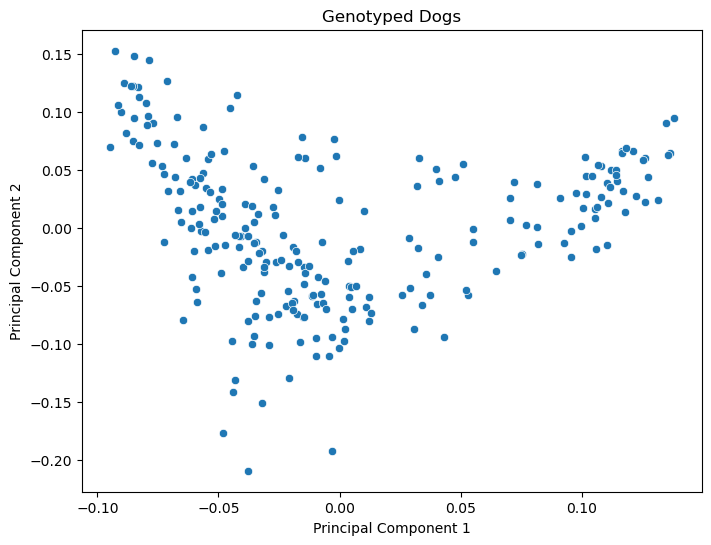

In [4]:
# Load the eigenvec file
pca_data = np.loadtxt("output/pca.eigenvec")

# Extract PC1 and PC2
pc1 = pca_data[:, 2]
pc2 = pca_data[:, 3]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pc1, y=pc2)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Genotyped Dogs")

plt.show()


Two clusters can be distinguished on the plot, although some individuals fall farther from the cluster.

I will run this later on scikit-learn and use K-Means Clustering. I also wonder if the clusters would appear clearer if we included only the SNPs that contribute to the phenotype.

<div style="background-color: #0096FF; padding: 10px;">GWAS</div>

The target variable in the ACL dataset is categorical, so we will use logistic regression on this analysis.

In [34]:
plink_gwas_command = "plink --bfile output/cr237_dryad_filtered --dog --logistic --out output/gwas"

run_plink(plink_gwas_command, GWAS)

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to output/gwas.log.
Options in effect:
  --bfile output/cr237_dryad_filtered
  --dog
  --logistic
  --out output/gwas

16384 MB RAM detected; reserving 8192 MB for main workspace.
115796 variants loaded from .bim file.
237 dogs (127 males, 110 females) loaded from .fam.
237 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 237 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997844.
115796 variants and 237 dogs pass filters and QC.
Among remaining phenotypes, 98 are cases and 139 are controls.
Writing logistic model associat

<div style="background-color: #0096FF; padding: 10px;">SUMMARY STATISTICS</div>

In [26]:
gwas_path = 'output/gwas.assoc.logistic'

summary = pd.read_csv(gwas_path, sep=r'\s+', engine='python')

print(summary.head())


   CHR                   SNP       BP A1 TEST  NMISS      OR   STAT       P
0    1  TIGRP2P259_rs8993730  3249189  G  ADD    237  1.7800  1.332  0.1830
1    1       BICF2G630707908  3273096  A  ADD    237  0.8318 -0.687  0.4921
2    1          BICF2P563564  3307151  A  ADD    237  1.7800  1.332  0.1830
3    1          BICF2P574107  3319643  G  ADD    237  1.7800  1.332  0.1830
4    1  TIGRP2P277_rs8525603  3342947  G  ADD    237  1.7800  1.332  0.1830


Acording to Baker et al., 2018, using the Bonferroni correction for multiple-testing is too conservative in dog genomes. To define genome-wide significance, they ran a permutation test on the phenotypes and ran the GWAS 1,000 times. I could reproduce this simulation in a future update. Meanwhile, I will use a p-value threshold of 5E-04.

In [29]:
0.05/115796

4.31793844346955e-07

In [34]:
summary[summary['P']<=5e-04]['SNP'].drop_duplicates()

609         BICF2P1409469
2209       BICF2S22959529
10053     BICF2G630464857
12580        BICF2P564273
14183     BICF2G630353235
               ...       
105425    BICF2G630245119
105427    BICF2G630245123
105428    BICF2G630245126
114077      BICF2P1086740
114078       BICF2P708698
Name: SNP, Length: 67, dtype: object

67 variants meet the significance threshold.

We want to know in which genes the SNPs are located.

In [27]:
# Create bed format
summary.insert(1, 'Start', summary['BP']-1)
summary['CHR'] = summary['CHR'].astype(str).replace('^','chr',regex=True)

bp = summary.pop('BP')
summary.insert(summary.columns.get_loc('SNP'), 'BP', bp)
summary = column_name_mapping(summary)

In [29]:
summary

,Chr,Start,End,SNP,A1,TEST,NMISS,OR,STAT,P
0,chr1,3249188,3249189,TIGRP2P259_rs8993730,G,ADD,237,1.7800,1.33200,0.1830
1,chr1,3273095,3273096,BICF2G630707908,A,ADD,237,0.8318,-0.68700,0.4921
2,chr1,3307150,3307151,BICF2P563564,A,ADD,237,1.7800,1.33200,0.1830
3,chr1,3319642,3319643,BICF2P574107,G,ADD,237,1.7800,1.33200,0.1830
4,chr1,3342946,3342947,TIGRP2P277_rs8525603,G,ADD,237,1.7800,1.33200,0.1830
...,...,...,...,...,...,...,...,...,...,...
115791,chr38,26751031,26751032,BICF2P1022668,G,ADD,237,1.0070,0.03885,0.9690
115792,chr38,26802746,26802747,BICF2P183416,A,ADD,237,1.0670,0.35430,0.7231
115793,chr38,26849405,26849406,BICF2P848709,A,ADD,237,1.0670,0.35430,0.7231
115794,chr38,26869797,26869798,BICF2P1439513,G,ADD,237,0.9545,-0.24820,0.8040


<div style="background-color: #0096FF; padding: 10px;">GENES</div>

We will use the gene loci annotations from CanFam3.1 to map SNPs to genes.

First we need to wrangle the data.

In [36]:
GFF3 = 'Canis_lupus_familiaris.CanFam3.1.104.gff3.gz'

with gzip.open(GFF3, 'rt', encoding='utf-8') as file:
    lines = [line.strip('\n').split('\t') for line in file if not line.startswith('#')]

CanFam = pd.DataFrame(lines, columns=['chromosome', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'])

# Add 'chr' string before each chromosome number
CanFam['chromosome'] = CanFam['chromosome'].astype(str).replace('^','chr',regex=True)

# Filter 'feature' by rows containing the string 'gene'
genes = CanFam[CanFam['feature']=='gene'].reset_index(drop=True)

# Split the attributes in the last column
attributes = [[subitem.split('=') for subitem in sublist] for sublist in genes['attributes'].str.split(';')]
#[re.sub(r'gene:',r'',n[0][1]) for n in attributes]

# Filter sublists containing gene_id, gene_type
filtered_attributes = [[item for item in sublist if item[0] in ['ID', 'biotype']] for sublist in attributes]

# Extract column names
columns = [[subitem[0] for subitem in sublist] for sublist in filtered_attributes][0]

# Create an 'attibutes' dataframe
rows = [[subitem[1] for subitem in sublist] for sublist in filtered_attributes]
attributes_df = pd.DataFrame(rows, columns=columns).replace('gene:', '', regex=True)#.iloc[:,[0,2,1]]

# Concatenate the gene loci and the attributes
canfam_bed = pd.concat([genes.iloc[:,[0,3,4]], attributes_df], axis=1)
canfam_bed = column_name_mapping(canfam_bed)


In [37]:
canfam_bed

,Chr,Start,End,ID,biotype
0,chr1,252103,322718,ENSCAFG00000000001,protein_coding
1,chr1,363607,365091,ENSCAFG00000000002,protein_coding
2,chr1,439463,440398,ENSCAFG00000041462,protein_coding
3,chr1,497071,565905,ENSCAFG00000000005,protein_coding
4,chr1,602264,635348,ENSCAFG00000000007,protein_coding
...,...,...,...,...,...
20252,chrX,123268867,123291467,ENSCAFG00000029471,protein_coding
20253,chrX,123324729,123438947,ENSCAFG00000019642,protein_coding
20254,chrX,123519430,123520066,ENSCAFG00000045470,protein_coding
20255,chrX,123620920,123621786,ENSCAFG00000030651,protein_coding


### Use pybedtools to intersect SNPs and genes

In [38]:
intersect_a_and_b(summary, canfam_bed)

,Chr_wa,Start_wa,End_wa,SNP_wa,A1_wa,TEST_wa,NMISS_wa,OR_wa,STAT_wa,P_wa,Chr_wb,Start_wb,End_wb,ID_wb,biotype_wb
0,chr1,3307150,3307151,BICF2P563564,A,ADD,237,1.780,1.3320,0.1830,chr1,3274993,3492201,ENSCAFG00000000019,protein_coding
1,chr1,3319642,3319643,BICF2P574107,G,ADD,237,1.780,1.3320,0.1830,chr1,3274993,3492201,ENSCAFG00000000019,protein_coding
2,chr1,3342946,3342947,TIGRP2P277_rs8525603,G,ADD,237,1.780,1.3320,0.1830,chr1,3274993,3492201,ENSCAFG00000000019,protein_coding
3,chr1,3347797,3347798,BICF2G630707918,G,ADD,237,1.343,1.5490,0.1215,chr1,3274993,3492201,ENSCAFG00000000019,protein_coding
4,chr1,3373251,3373252,TIGRP2P286_rs8866509,A,ADD,237,1.780,1.3320,0.1830,chr1,3274993,3492201,ENSCAFG00000000019,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48104,chr38,23803881,23803882,BICF2S23116003,G,ADD,237,1.213,0.7741,0.4389,chr38,23711780,23871846,ENSCAFG00000011358,protein_coding
48105,chr38,23828702,23828703,BICF2P180298,G,ADD,237,1.144,0.5396,0.5895,chr38,23711780,23871846,ENSCAFG00000011358,protein_coding
48106,chr38,23847989,23847990,BICF2P119707,T,ADD,237,1.120,0.5849,0.5586,chr38,23711780,23871846,ENSCAFG00000011358,protein_coding
48107,chr38,23852238,23852239,BICF2P219250,G,ADD,237,1.120,0.5849,0.5586,chr38,23711780,23871846,ENSCAFG00000011358,protein_coding


NEXT:
- Check the build in both dfs in case it's necessary to LiftOver

https://ftp.ensembl.org/pub/release-104/
https://may2021.archive.ensembl.org/Canis_lupus_familiaris/Info/Index
https://research.nhgri.nih.gov/dog_genome/index.shtml
https://www.broadinstitute.org/scientific-community/science/projects/mammals-models/dog/dog-genome-links
